# 1 Lasso and Ridge regression model for diamond price prediction

# 1.1 Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 1.2 Loading dataset and data preprocessing

In [2]:
df = pd.read_csv("diamonds.csv")
df.head()


,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## 1.2.1 Exploratory Data Analysis

In [3]:
df.shape

(53940, 11)

The column named "Unnamed: 0" provides no information apart from serial numbers which is present by default; hence this column can be removed

In [4]:
df.drop("Unnamed: 0", axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [6]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


From the above summary, we notice that there are certain values of x, y and z that are equal to zero. This indicates that such rows correspond to erroneous data which can be safely removed from our dataset

In [7]:
cs_1 = df["x"]== 0
cs_2 = df["y"]== 0
cs_3 = df["z"]== 0

idx_val = df[(cs_1) | (cs_2) | (cs_3)].index

In [8]:
df.drop(idx_val, inplace=True)

In [9]:
# Check for null values

df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

We prepare a separate list of numerical and categorical features which allows us to analyse them more conveniently as and when required

In [10]:
num_fea = df.select_dtypes(include=["int", "float"]).columns.to_list()
cat_fea = df.select_dtypes(include=["object"]).columns.to_list()

print("Numerical features are ", num_fea)
print("categorical features are ", cat_fea)

Numerical features are  ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
categorical features are  ['cut', 'color', 'clarity']


In [11]:
df_num = df[num_fea]
df_cat = df[cat_fea]

# 1.2.1.1 Data visualization of features

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


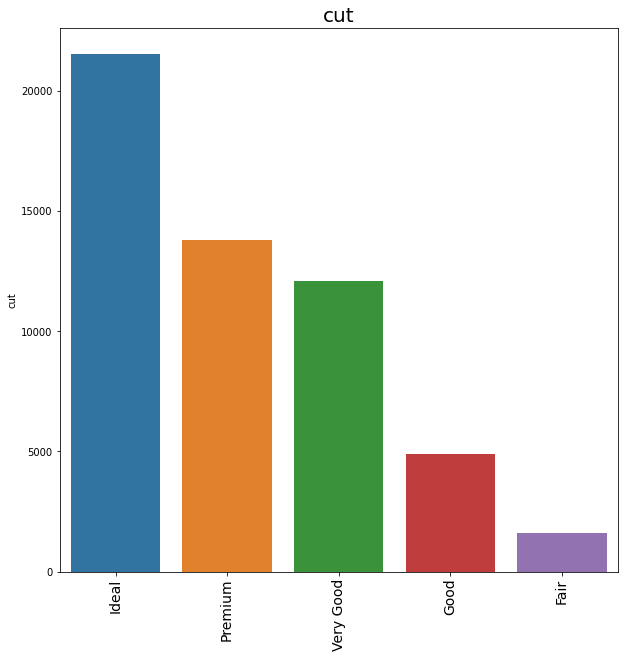

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


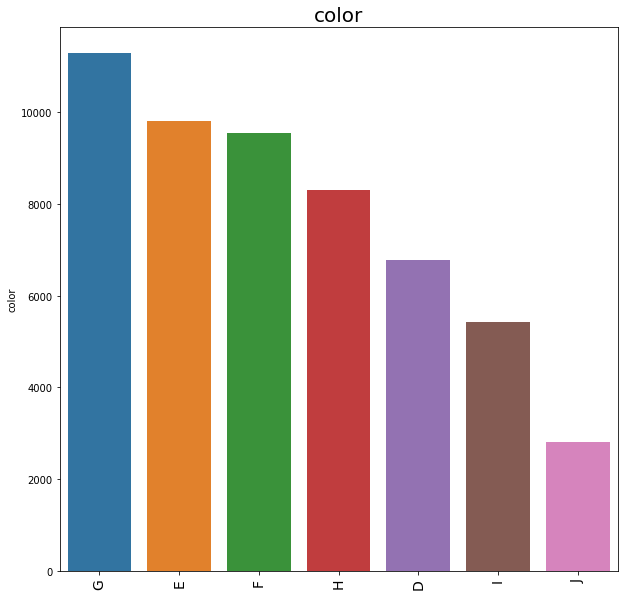

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


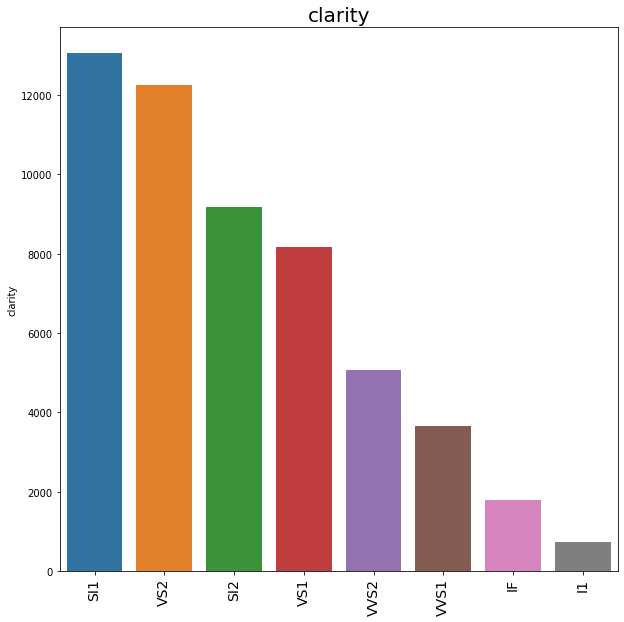

In [12]:
for i in df_cat.columns:
    plt.figure(figsize=(10,10))
    sns.barplot(df_cat[i].value_counts().index, df_cat[i].value_counts()).set_title(i)
    plt.xticks(fontsize=14, rotation = "vertical")
    plt.title(i, fontsize=20)
    plt.show()

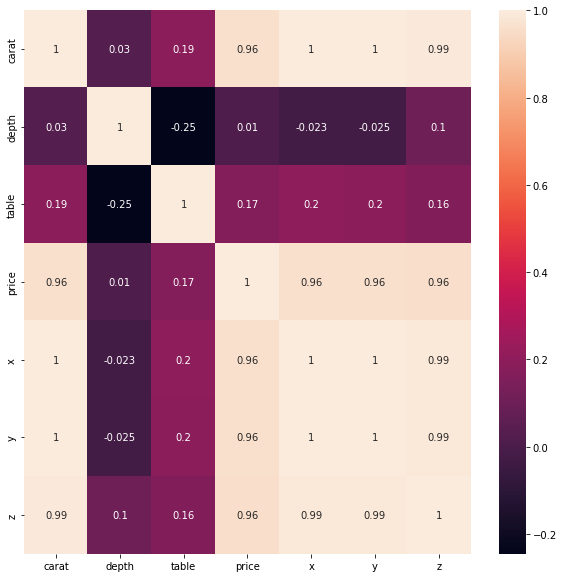

In [13]:
corrmat = df_num.corr(method = "spearman")
plt.figure(figsize=(10,10))
g=sns.heatmap(corrmat,annot=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


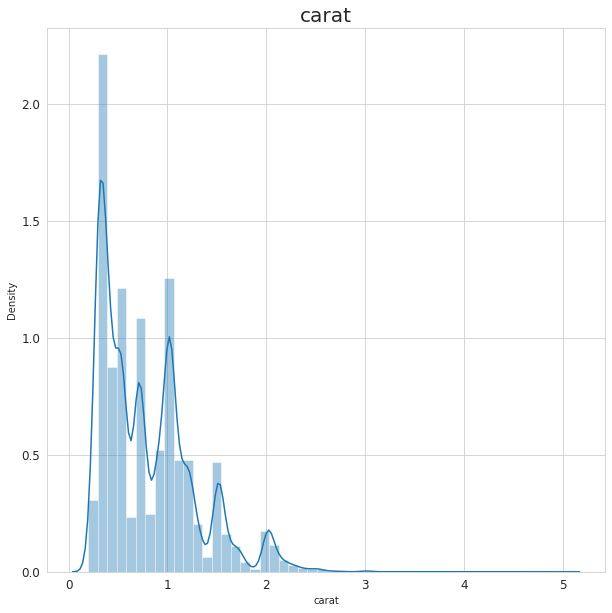

The skewness is  1.1161764230767832


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


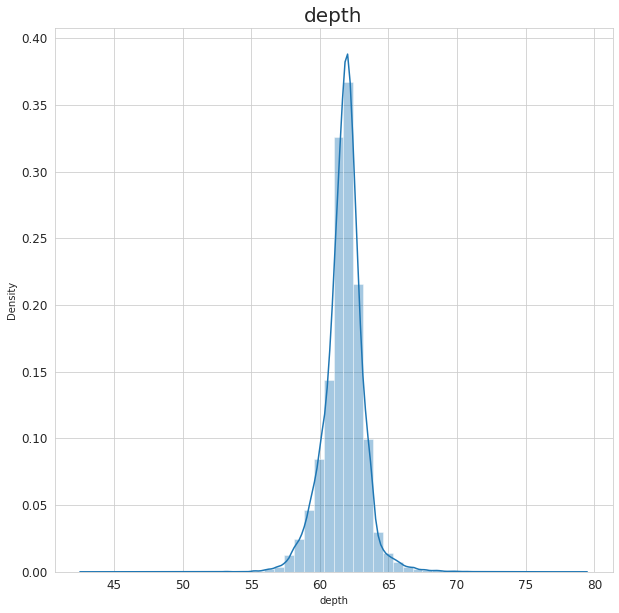

The skewness is  -0.08172422481120903


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


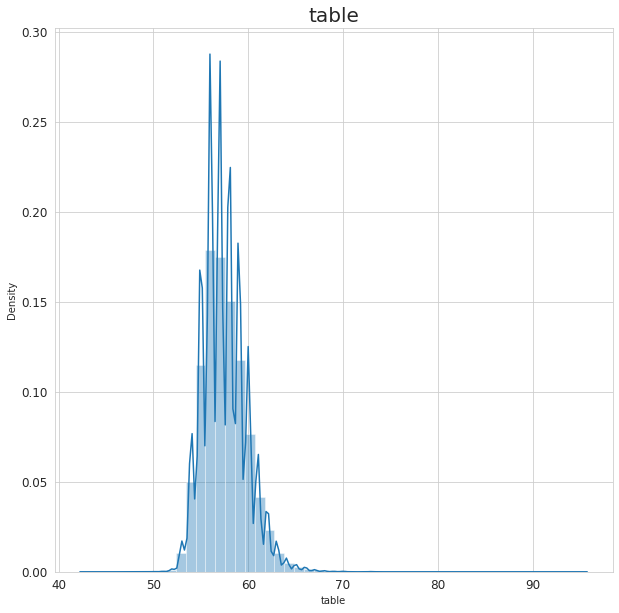

The skewness is  0.7967773253895398


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


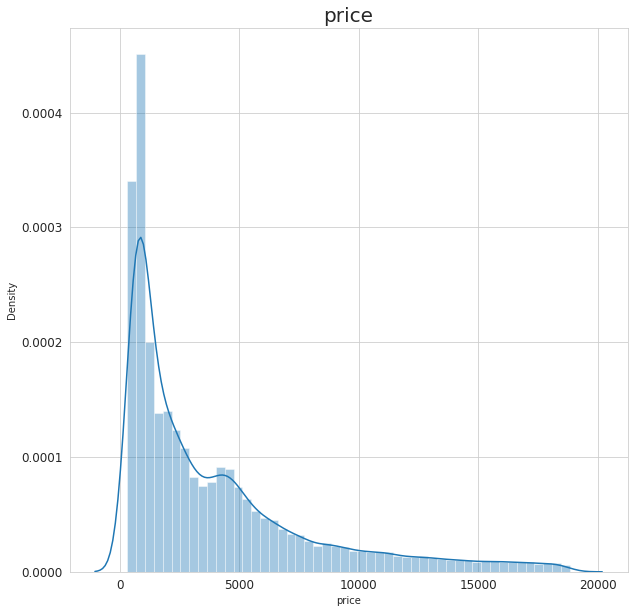

The skewness is  1.61830361290786


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


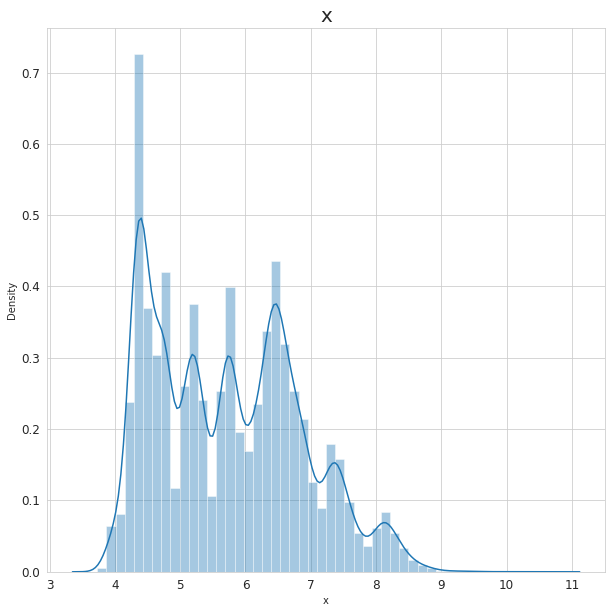

The skewness is  0.39833641878127574


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


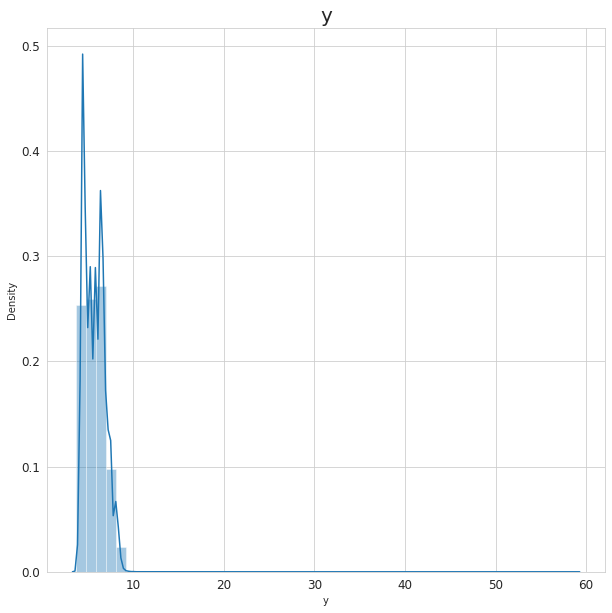

The skewness is  2.4621421115578563


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


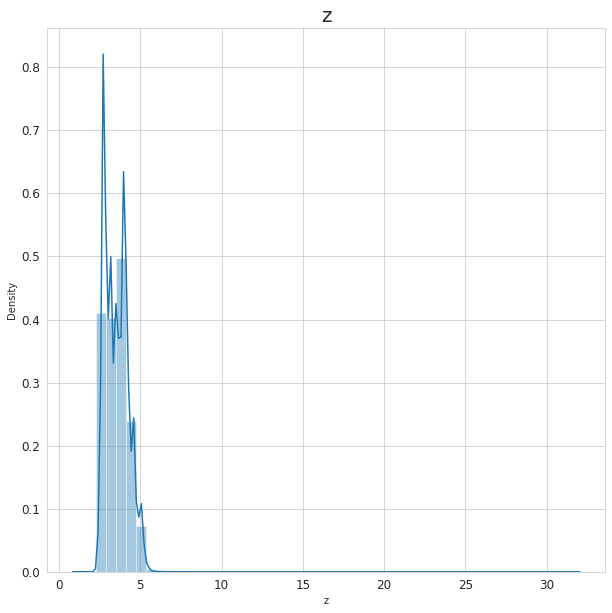

The skewness is  1.5854456596485427


In [14]:
for fea in df_num.columns:
    plt.figure(figsize=(10,10))
    sns.set_style('whitegrid')
    sns.distplot(df[fea], kde=True, bins= 50)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(fea, fontsize=20)
    plt.show()
    print("The skewness is ", skew(df[fea]))
    

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


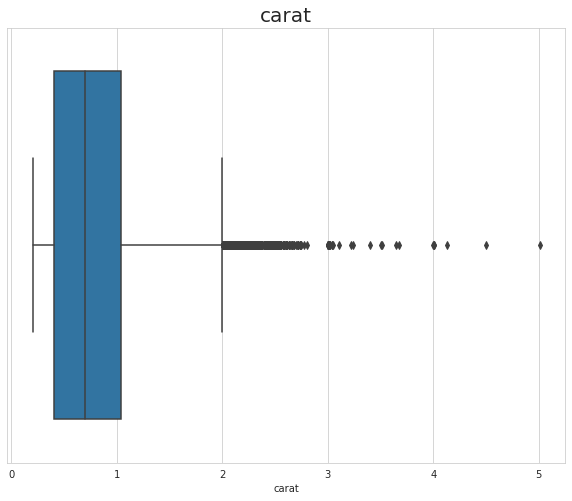

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


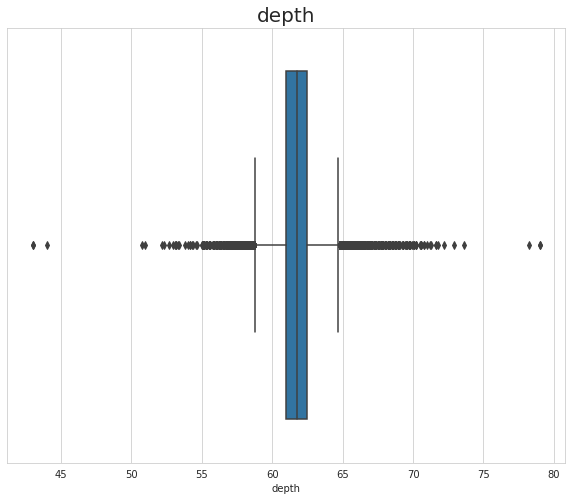

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


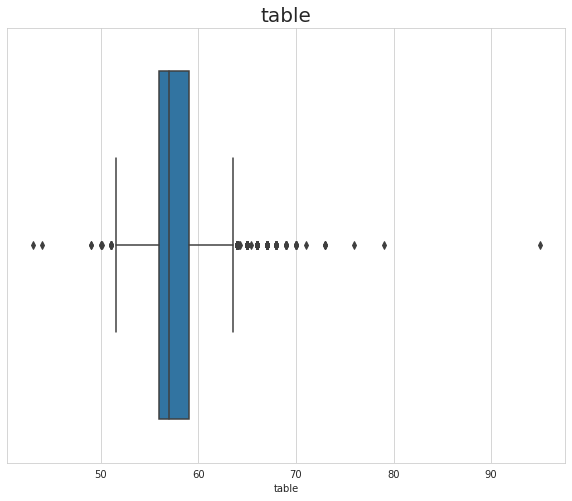

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


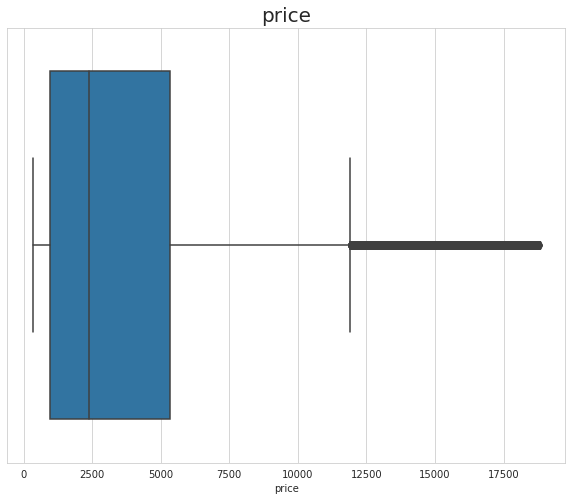

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


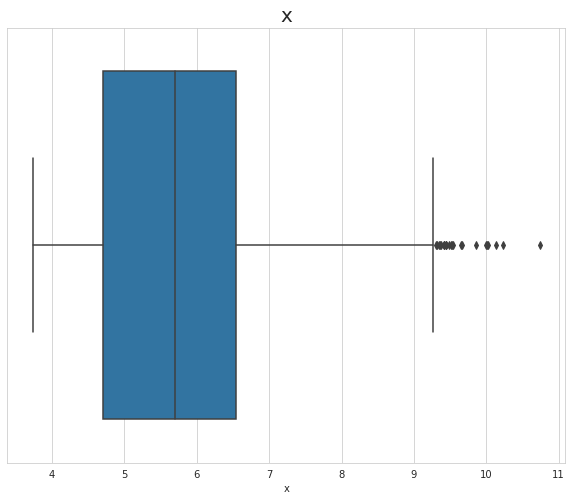

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


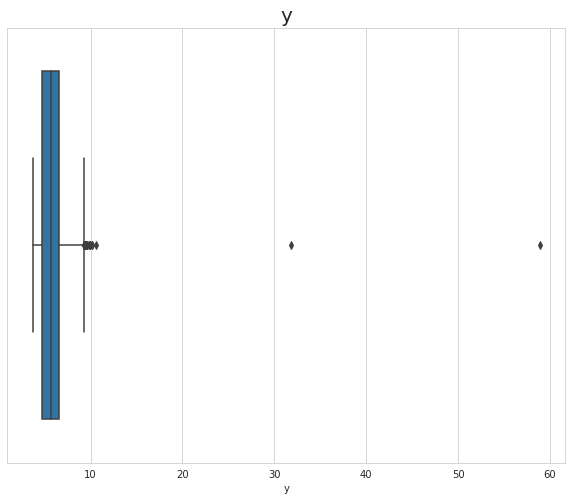

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


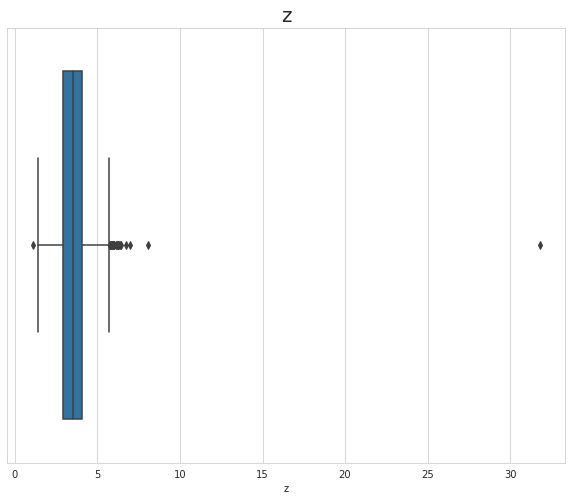

In [15]:
for fea in df_num.columns:
    plt.figure(figsize=(10,8))
    sns.boxplot(df[fea])
    plt.title(fea, fontsize=20)
    plt.show()
    

# 1.2.2 Feature Engineering

# 1.2.2.1 Handling ordinal variables
The categorical features of the datset color, quality and cut are actually nominal variables i.e each of the unique values have an order within them. For e.g, the feature clarity has values "IF" being the highest and "I1" as the lowest. Thus, it is reasonable to expect that the price of a diamond piece should have a strong correlation with the quality of each categorical feature. Hence, we arrange the values of these features as numerical digits with regards to their individual rank.

In [16]:
cut_dic = {"Ideal": 1, "Premium": 2, "Very Good": 3, "Good":4, "Fair":5}
color_dic = {"D":1, "E":2, "F":3, "G":4, "H":5, "I":6, "J":7}
clarity_dic = {"IF":1, "VVS1":2, "VVS2":3, "VS1":4, "VS2":5, "SI1":6, "SI2":7, "I1":8}

df["cut_order"]= df.cut.map(cut_dic)
df["color_order"]= df.color.map(color_dic)
df["clarity_order"] = df.clarity.map(clarity_dic)

In [17]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,cut_order,color_order,clarity_order
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,1,2,7
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,2,2,6
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,4,2,4
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,2,6,5
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,4,7,7


Upon creating the new columns for the categorical variables, we delete the former as it provides no additional information

In [18]:
df.drop(["cut", "color", "clarity"], axis=1, inplace=True)

# 1.2.2.2 Forming new feature by combining dimensions
The correlation heatmap obtained in the EDA section also reveals a problem with multicollinearity, as a number of variables like x,y and z have strong inter-correlation. This is undesirable especially in a linear regression model, hence, we combine the three dimensions x, y and z to form a new feature as volume of the diamond piece.

In [19]:
df["Volume"] = df["x"]*df["y"]*df["z"]

In [20]:
df.drop(["x","y", "z"], axis=1, inplace=True)

The impact of the feature engineering can be analysed through the correlation heatmap again, which reveals a decrement in the multicollinearity among all features

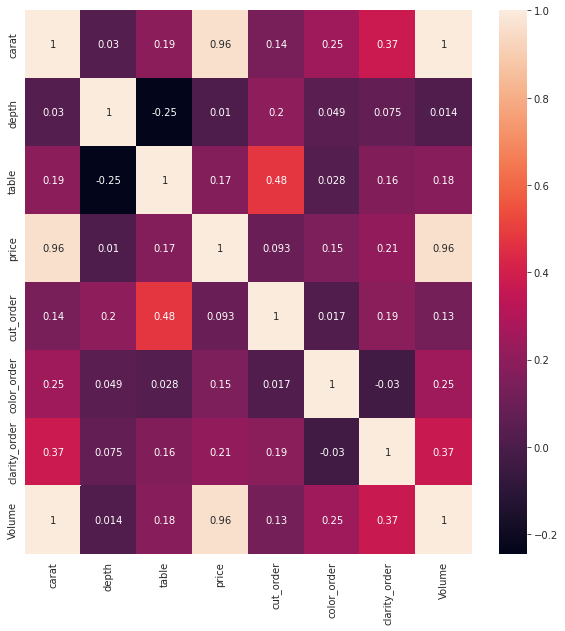

In [21]:
corrmat = df.corr(method = "spearman")
plt.figure(figsize=(10,10))
g=sns.heatmap(corrmat,annot=True)

# 1.2.3 Outlier handling

As the boxplots in EDA section clearly shows the presence of outliers which can negatively impact our model performance, we treat them using IQR technique.

In [22]:
q1_crt = df["carat"].quantile(0.25)
q3_crt = df['carat'].quantile(0.75)

iqr_crt = q3_crt - q1_crt

up_crt = q3_crt + 1.5*iqr_crt
low_crt = q1_crt - 1.*iqr_crt

q1_dph = df["depth"].quantile(0.25)
q3_dph = df['depth'].quantile(0.75)

iqr_dph = q3_dph - q1_dph

up_dph = q3_dph + 1.5*iqr_dph
low_dph = q1_dph - 1.*iqr_dph

q1_prc = df["price"].quantile(0.25)
q3_prc = df['price'].quantile(0.75)

iqr_prc = q3_prc - q1_prc

up_prc = q3_prc + 1.5*iqr_prc
low_prc = q1_prc - 1.*iqr_prc

q1_vol = df["Volume"].quantile(0.25)
q3_vol = df['Volume'].quantile(0.75)

iqr_vol = q3_vol - q1_vol

up_vol = q3_vol + 1.5*iqr_vol
low_vol = q1_vol - 1.*iqr_vol

c1 = df['carat']> up_crt
c2 = df['carat']< low_crt
c3 = df['depth']> up_dph
c4 = df['depth']< low_dph
c5 = df['price']> up_prc
c6 = df['price']< low_prc
c7 = df['Volume']> up_vol
c8 = df["Volume"]< low_vol



In [23]:
df.loc[c1, "carat"] = up_crt
df.loc[c2, "carat"]= low_crt
df.loc[c3, "depth"]= up_dph
df.loc[c4, "depth"]= low_dph
df.loc[c5, "price"]= up_prc
df.loc[c6, 'price']= low_prc
df.loc[c7, 'Volume']= up_vol
df.loc[c8, "Volume"]= low_vol

# 1.2.3.1 Visulalization to check the impact of outlier treatment

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


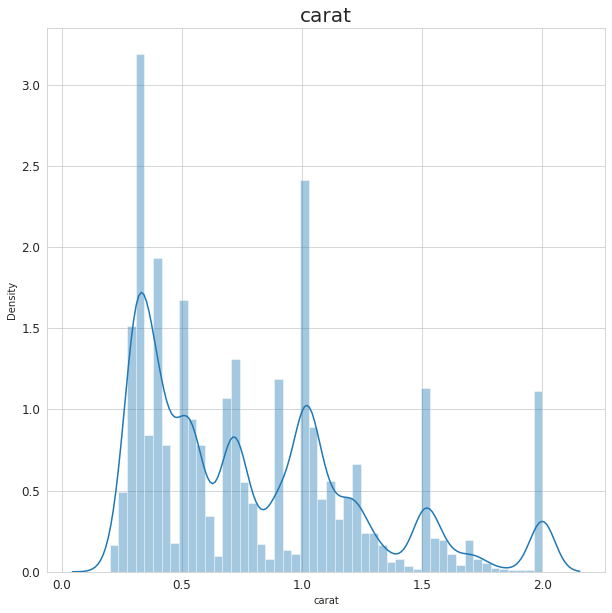

The skewness is  0.9001152851898577


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


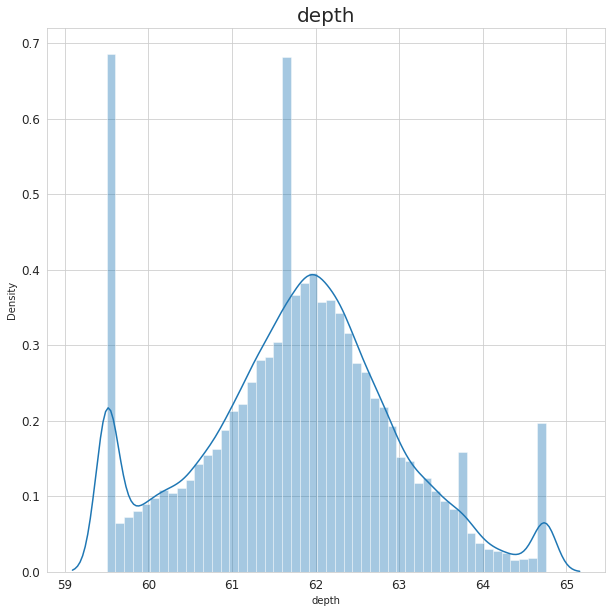

The skewness is  0.021378054375433584


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


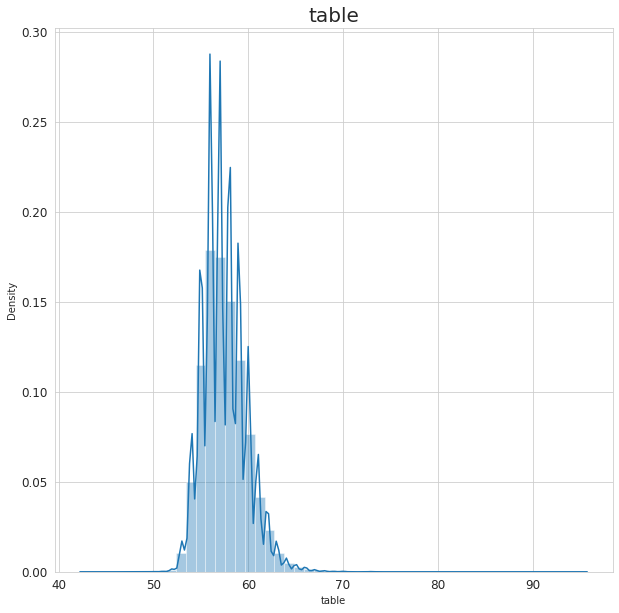

The skewness is  0.7967773253895398


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


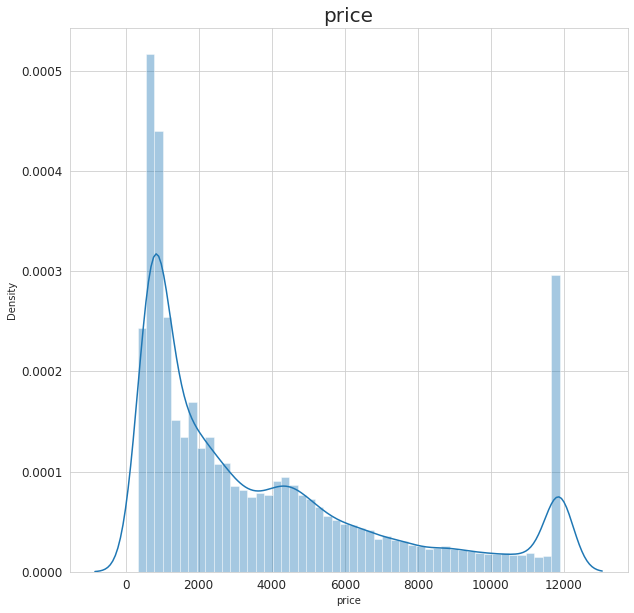

The skewness is  1.1485547664627451


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


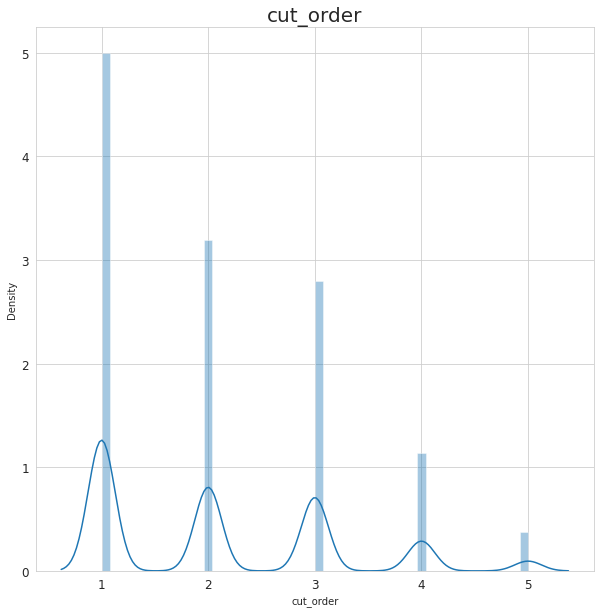

The skewness is  0.717168492199481


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


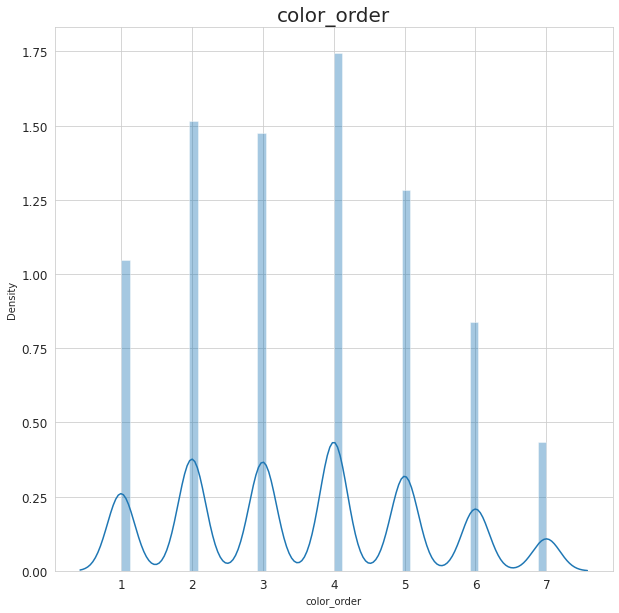

The skewness is  0.18962466888924223


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


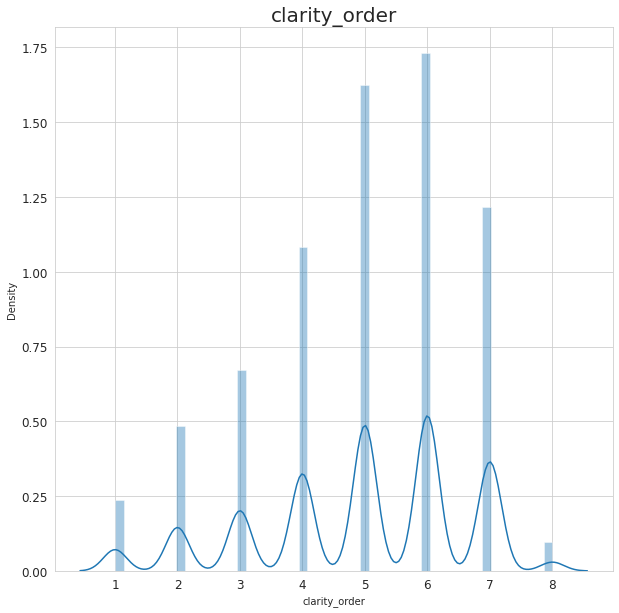

The skewness is  -0.5514555445175061


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


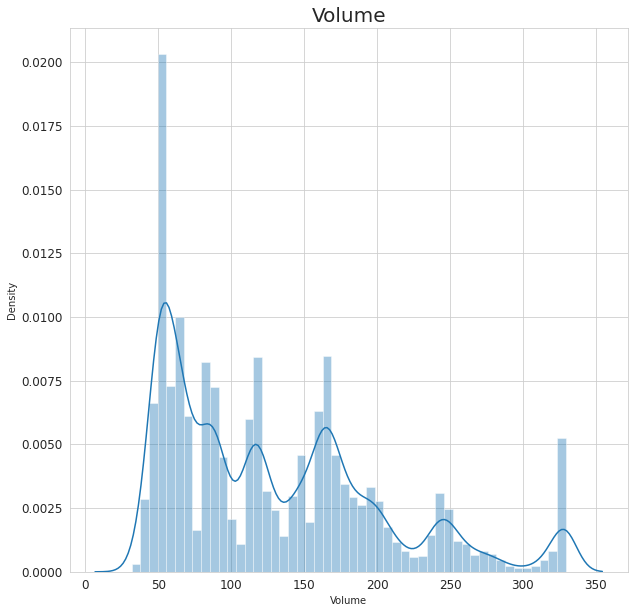

The skewness is  0.9173799504504824


In [24]:
for fea in df.columns:
    plt.figure(figsize=(10,10))
    sns.set_style('whitegrid')
    sns.distplot(df[fea], kde=True, bins= 50)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(fea, fontsize=20)
    plt.show()
    print("The skewness is ", skew(df[fea]))

# 1.2.4 Preparation of training and test data

In [25]:
y = df["price"]
df.drop("price", axis=1, inplace=True)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=42)

# 1.2.5 Data scaling

In [27]:
scaler = StandardScaler()

X_tr_sc = scaler.fit_transform(X_train)
X_tst_sc = scaler.transform(X_test)

# 1.3 Model implementation

# 1.3.1 Linear Regression Model(Unregularized)

In [28]:
lr = LinearRegression()
model_lr = lr.fit(X_tr_sc, y_train)


In [29]:
tr_scor = model_lr.score(X_tr_sc, y_train)
tst_scor = model_lr.score(X_tst_sc, y_test)

print("Training accuracy ", tr_scor)
print("Test accuracy ", tst_scor)

Training accuracy  0.9302821800477876
Test accuracy  0.9314256556949928


# 1.3.2 Ridge Regression Model

In [30]:
rg = Ridge().fit(X_tr_sc, y_train)
print("Ridge training aacuracy", rg.score(X_tr_sc, y_train))
print("Ridge test accuracy ", rg.score(X_tst_sc, y_test))

Ridge training aacuracy 0.9302821764682219
Ridge test accuracy  0.9314236747820482


# 1.3.3 Lasso Regression Model

In [31]:
lsso = Lasso().fit(X_tr_sc, y_train)

print("Lasso training aacuracy", lsso.score(X_tr_sc, y_train))
print("Lasso test accuracy ", lsso.score(X_tst_sc, y_test))

Lasso training aacuracy 0.9302741905586305
Lasso test accuracy  0.9315115668711066


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.724e+08, tolerance: 4.483e+07
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Predictions of lasso and ridge regression on test dataset

In [32]:
y_pred_rg = rg.predict(X_tst_sc)
y_pred_lsso = lsso.predict(X_tst_sc)

# 1.3.4 Evalution of model performance(lasso and ridge)

In [33]:
print("MAE in Ridge ", mean_absolute_error(y_test, y_pred_rg))
print("MAE in Lasso ", mean_absolute_error(y_test, y_pred_lsso))

print("RMSE in Ridge ", np.sqrt(mean_squared_error(y_test, y_pred_rg)))
print("RMSE in Lasso ", np.sqrt(mean_squared_error(y_test, y_pred_lsso)))

print("R2 score in Ridge ", r2_score(y_test, y_pred_rg))
print("R2 score in Lasso ", r2_score(y_test, y_pred_lsso))

MAE in Ridge  658.564364513387
MAE in Lasso  658.1498939141542
RMSE in Ridge  893.0535379471308
RMSE in Lasso  892.4810553355715
R2 score in Ridge  0.9314236747820482
R2 score in Lasso  0.9315115668711066


In [34]:
!jupyter nbconvert --to html diamond_price_pred.ipynb.ipynb  

[NbConvertApp] WARNING | pattern u'diamond_price_pred.ipynb.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'
--inpl